## Notebook 4 : Trends of property values 

## 1 - Data processing ##

Overview of the notebook’s objective and the data used.


This notebook will help identifying the past trends and foresee the evolution of the property values. We will base this analysis on historical data. 

Retrospective analysis : How did the prices evolve throughout time ?


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

In [5]:
# Read in the data
df_tf = pd.read_csv('df_complete.csv', low_memory=False)

In [6]:
df_clean = df_tf[
    (df_tf['Valeur fonciere'] > 1000) & 
    (
        (df_tf['Surface reelle bati'] > 0) | (df_tf['Nombre pieces principales'] > 0) | (df_tf['Surface terrain']>10) &
        (df_tf['Type local']!='0')
    )
]
drop_columns=['Code commune', 'Code type local','Nombre de lots']
df_clean=df_clean.drop(columns=drop_columns, errors='ignore')

In [7]:
#### CONVERTS TO THE RIGHT TYPE ####
category_convert = ['Nature mutation', 'Code postal', 'Commune', 'Code departement', 'Type local']
df_clean[category_convert] = df_clean[category_convert].astype('category')

df_clean['Date mutation'] = pd.to_datetime(df_clean['Date mutation'], errors = 'coerce')
df_clean['Date mutation'] = df_clean['Date mutation'].interpolate(method='linear')

df_clean['Valeur fonciere']=df_clean['Valeur fonciere'].replace({'\xa0':'',',':'.'}, regex=True)
df_clean['Valeur fonciere']=pd.to_numeric(df_clean['Valeur fonciere'], errors='coerce')
df_clean['Mois'] = df_clean['Date mutation'].dt.month
df_clean['annee'] = df_clean['Date mutation'].dt.year
df_clean['Jour'] = df_clean['Date mutation'].dt.day

df_clean.info()
#print(df_clean[['Date mutation', 'Mois', 'Annee']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 7902997 entries, 0 to 17810873
Data columns (total 14 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   Date mutation              datetime64[ns]
 1   Nature mutation            category      
 2   Valeur fonciere            float64       
 3   Voie                       object        
 4   Code postal                category      
 5   Commune                    category      
 6   Code departement           category      
 7   Type local                 category      
 8   Surface reelle bati        float64       
 9   Nombre pieces principales  float64       
 10  Surface terrain            float64       
 11  annee                      int32         
 12  Mois                       int32         
 13  Jour                       int32         
dtypes: category(5), datetime64[ns](1), float64(4), int32(3), object(1)
memory usage: 566.7+ MB


In [8]:
missing_values = df_clean.isnull().sum()
#missing_values

In [9]:
#### CHECK DUPLICATES ####
df_clean.drop_duplicates(keep='last', inplace=True)
df_clean = df_clean.sort_values('Date mutation').drop_duplicates(subset=['Valeur fonciere', 'Code postal', 'Commune', 'Nature mutation', 'annee'], keep='last')
# df_clean.duplicated().sum()

During the processing of duplicates in the DVF data base, it is frequent to encounter partial duplicates, meaning that some rows aren’t completely exact copies of a row, but they represent the same property. There are only few variations in certain columns.

Partial duplicates share the following common values : Property value, Code department, Town (Commune), the nature of the transaction, the year of the transaction. The values often differ on the following characteristics : Type of property, built surface, land surface, the month of the transaction.

Therefore, it is in reality more complex to manipulate and reject the duplicates. On one hand, we remove the exact duplicates and we keep the last occurrence, on the other hand, we remove the partial duplicates by creating a subset.

However, we must consider that certain rows could be removed while they are exploitable data, but it was important to make a trade-off to ensure a consistent data base and avoid an overload from duplicates.

##### Description of property values, built surface and land surface #####

In [10]:
df_clean[['Valeur fonciere', 'Surface reelle bati', 'Surface terrain']].describe()

,Valeur fonciere,Surface reelle bati,Surface terrain
count,4.218283e+06,4.218283e+06,4.218283e+06
mean,3.145719e+05,1.030868e+02,5.077559e+02
std,7.318489e+06,6.213762e+02,3.223688e+03
min,1.001000e+03,0.000000e+00,0.000000e+00
25%,1.110000e+05,4.400000e+01,0.000000e+00
50%,1.860000e+05,7.400000e+01,1.770000e+02
75%,3.015000e+05,1.020000e+02,5.790000e+02
max,1.415000e+10,2.650000e+05,3.760000e+06


In [11]:
high_values = df_clean[df_clean['Valeur fonciere'] > 1e6]
high_value_properties_sorted = high_values.sort_values('Valeur fonciere', ascending=False)

### Outliers ###

In [12]:
Q1 = df_clean['Valeur fonciere'].quantile(0.25)
Q3 = df_clean['Valeur fonciere'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [13]:
outliers = df_clean[(df_clean['Valeur fonciere'] < lower_bound) | 
                    (df_clean['Valeur fonciere'] > upper_bound)]
non_outliers = df_clean[(df_clean['Valeur fonciere'] >= lower_bound) & (df_clean['Valeur fonciere'] <= upper_bound)]

outliers.groupby(['annee', 'Type local'], observed=False)['Valeur fonciere'].agg(['count', 'mean', 'std'])

#### METRICS COMPARISON ####
# All
mean_all = df_clean['Valeur fonciere'].mean()
median_all = df_clean['Valeur fonciere'].median()

# Non-outliers
mean_non_outliers = non_outliers['Valeur fonciere'].mean()
median_non_outliers = non_outliers['Valeur fonciere'].median()

# Outliers
mean_outliers = outliers['Valeur fonciere'].mean()
median_outliers = outliers['Valeur fonciere'].median()

print("General mean :", mean_all)
print("General median :", median_all)
print("\nNon-outliers mean :", mean_non_outliers)
print("Non-outliers median :", median_non_outliers)
print("\nOutliers mean :", mean_outliers)
print("Outliers median :", median_outliers)

General mean : 314571.8959139558
General median : 186000.0

Non-outliers mean : 199410.04690305435
Non-outliers median : 175000.0

Outliers mean : 1832406.0027162067
Outliers median : 837600.0


### 2. How have property values and transactions volume evolved over 2019 - 2024 period ?
 ###

#### 2.1 Analysis of volume transactions ####

Here is the evolution of the number of transactions from 2019 to 2024. 
We can observe an increase and a peak of the volume of transactions in 2022, and a decrease in the next years.

In [14]:
# Statistiques descriptives des colonnes temporelles
df_clean[['Mois', 'annee', 'Jour']].describe()
df_clean['Annee-Mois'] = df_clean['Date mutation'].dt.to_period('M')

# Nombre d'observations par mois et par année pour observer les tendances
observations_par_mois = df_clean['Annee-Mois'].value_counts().sort_index()
observations_par_annee = df_clean['annee'].value_counts().sort_index()

#print(observations_par_mois)
print("Nombre approximatif de transactions par an : \n")
print(observations_par_annee)

Nombre approximatif de transactions par an : 

annee
2019    492574
2020    817424
2021    950031
2022    909607
2023    728922
2024    319725
Name: count, dtype: int64


The figure below represents the evolution by month and year of the transactions from 2019 to 2024, depending on the type of property : house, apartment, industrial and commercial lands, and dependencies. 
We can highlight seasonal trends, differences between type of property, and identity the impact of external events on the global volume of transactions. 

In [123]:
mutations_analyse=df_clean.copy()
mutations_analyse['Date mutation'] = pd.to_datetime(mutations_analyse['Date mutation'])
#mutations_analyse['Annee'] = mutations_analyse['Date mutation'].dt.year
mutations_analyse['Annee-Mois'] = mutations_analyse['Date mutation'].dt.to_period('M').astype(str)

def plot_interactive(annee_range, type_bien=None):
    filtered_data = mutations_analyse[
        (mutations_analyse['annee'] >= annee_range[0]) & 
        (mutations_analyse['annee'] <= annee_range[1])
    ]
    
    if type_bien: 
        filtered_data = filtered_data[filtered_data['Type local'] == type_bien]
    
    sequences = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)
        .size()
        .reset_index(name='count')
    )

    plt.figure(figsize=(20, 6))
    sns.lineplot(
        data=sequences,
        x='Annee-Mois', y='count',
        hue='Type local', marker='o', palette='Set2'
    )
    plt.title('Evolution of transactions (Year-Month)')
    plt.xlabel('Year-Month')
    plt.ylabel('N Transactions')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Type de Bien')
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2021, 2023],
    min=2019, max=2024, step=1,
    description='Years :',
    continuous_update=False
)

type_bien_widget = widgets.Dropdown(
    options=[None] + list(mutations_analyse['Type local'].unique()),
    value=None,
    description="Type :"
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    type_bien=type_bien_widget,
    show_median=widgets.Checkbox(value=True, description="Afficher Médiane"),
    show_mean=widgets.Checkbox(value=False, description="Afficher Moyenne")
)


interactive(children=(IntRangeSlider(value=(2021, 2023), continuous_update=False, description='Years :', max=2…

<function __main__.plot_interactive(annee_range, type_bien=None)>

##### Characteristics of the figure : #####

- Axis x represents the months and years from January 2019 to December 2024, to illustrate the a continuous time progression. It is possible to modify the range of the period to be observed.
- On axis y, the number of transactions per month.
- Different line plots, each one assigned to a type of property. 

We can notice a seasonal pattern in terms of number of transactions, regardless of the type of property. An increase in transactions can be identified in the beginning of the year, especially for 2020 to 2023. This increase often appears in January-February. 
Moreover, the volume reaches a peak, generally during estival time (June-July). Finally, the volume decreases at the end of the year, usually by September. 

Houses and apartments have a higher demand because they provide essential housing needs, while industrial and commercial buildings have a restrained target clientele and provide specific needs. This explains why its market is less dynamic.

The increasing demand for individual properties can be seen in the post-Covid context, when remote work has made the meed for space and comfort even more important, also by the type of buyers (usually families).

Let’s examine how means and medians of the property values have changed annually and monthly during this period.

#### 2.2 Annual and monthly evolution of property values ####

The first analyse is about understanding global trends and the evolution of real estate market during this period.
Below, figures that plot the evolution of the median and mean of property values. Separating or including the outliers is an important step to understand the real trend of the values.

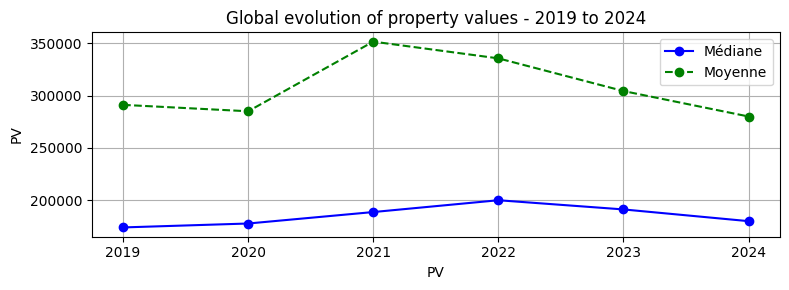

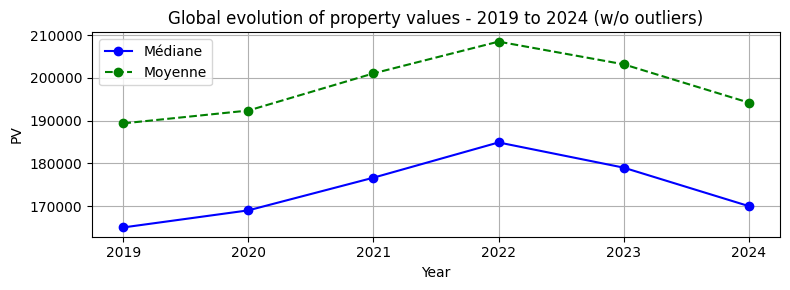

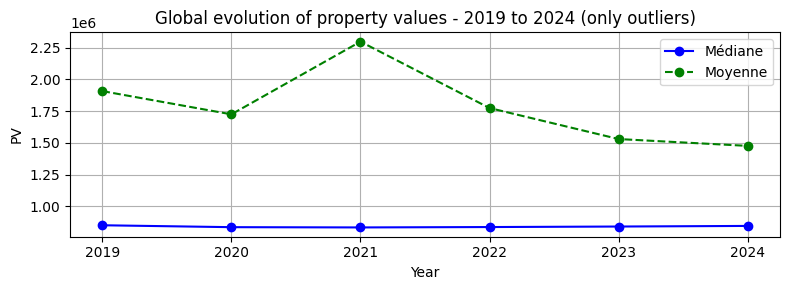

In [32]:
#with outliers 
median_peryear = df_clean.groupby('annee')['Valeur fonciere'].median().reset_index()
mean_peryear = df_clean.groupby('annee')['Valeur fonciere'].mean().reset_index()
def plot_evolution_all():
    plt.figure(figsize=(8, 3))
    plt.plot(median_peryear['annee'], median_peryear['Valeur fonciere'], marker='o', label='Médiane', color='blue')
    plt.plot(mean_peryear['annee'], mean_peryear['Valeur fonciere'], marker='o', label='Moyenne', color='green', linestyle='--')

    plt.title('Global evolution of property values - 2019 to 2024')
    plt.xlabel('PV')
    plt.ylabel('PV')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_evolution_all()

#wo outliers
median_nonoutliers=non_outliers.groupby('annee')['Valeur fonciere'].median().reset_index()
mean_nonoutliers=non_outliers.groupby('annee')['Valeur fonciere'].mean().reset_index()

def plot_evolution_nonoutliers():
    plt.figure(figsize=(8, 3))
    plt.plot(median_nonoutliers['annee'], median_nonoutliers['Valeur fonciere'], marker='o', label='Médiane', color='blue')
    plt.plot(mean_nonoutliers['annee'], mean_nonoutliers['Valeur fonciere'], marker='o', label='Moyenne', color='green', linestyle='--')

    plt.title('Global evolution of property values - 2019 to 2024 (w/o outliers)')
    plt.xlabel('Year')
    plt.ylabel('PV')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_evolution_nonoutliers()

median_outliers=outliers.groupby('annee')['Valeur fonciere'].median().reset_index()
mean_outliers=outliers.groupby('annee')['Valeur fonciere'].mean().reset_index()

#only outliers
def plot_evolution_outliers():
    plt.figure(figsize=(8, 3))
    plt.plot(median_outliers['annee'], median_outliers['Valeur fonciere'], marker='o', label='Médiane', color='blue')
    plt.plot(mean_outliers['annee'], mean_outliers['Valeur fonciere'], marker='o', label='Moyenne', color='green', linestyle='--')

    plt.title('Global evolution of property values - 2019 to 2024 (only outliers)')
    plt.xlabel('Year')
    plt.ylabel('PV')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_evolution_outliers()


The median is the central value in a distribution. Half the value below, the other half above. The measure is less influenced by outliers (extreme values). The mean is more influenced by the outliers.

What we can deduct from those graphs is that outliers strongly affect the global mean (Figure 1), but isolating them, we obtain a clearer trend for the common values (figure 2). Indeed, mean and median are quite close and have a similar evolution.
On the third graph, values are extremely high, explaining why the global mean was influenced.

We may notice that in the non outliers graph, peak is located at 2022 while for the others peak appears in 2021.

For the next analysis, we will focus mainly on non outliers to establish broader conclusions et observe standard trends of estate market.
Still, understanding the dynamics of extreme values is necessary to know where they come from.

##### Statistics #####

The interpretation of statistics is used to obtain practical insights on the market evolution. 
Below is a table composed of the mean, median and standard deviation for each year.

In [17]:
annual_stats = non_outliers.groupby('annee')['Valeur fonciere'].agg(['mean', 'median', 'std']).reset_index()
annual_stats

,annee,mean,median,std
0,2019,189365.531240,165000.0,119529.815620
1,2020,192369.444734,169000.0,121188.751950
2,2021,201065.238020,176650.0,125465.137842
3,2022,208503.690000,184900.0,127639.138456
4,2023,203194.626697,179000.0,126929.749798
5,2024,194225.930634,170000.0,123672.239267


#### Zooming on mean value transactions per year (w/o outliers) ####

- 2019 : 189 366 €
- 2020 : 192 369 € (+ 3 003 € soit +1.59%)
- 2021 : 201 065 € (+ 8 696 € soit +4.52%)
- 2022 : 208 504 € (+ 7 439 € soit +3.70%)
- 2023 : 203 195 € (- 5 309 € soit -2.55%)
- 2024 : 194 226 € (- 8 969 € soit -4.41%)

In 2021, there was a 4.52% increase compared to 2020. The rise in prices can be explained by several factors. First, the post-Covid economic recovery may have led to a surge in activity in the real estate market, especially since the interest rate reached its lowest point of around 1% since June 2020 (Source: L'Observatoire Crédit Logement, https://www.immobilier-danger.com/evolution-taux-immobilier.html). Plus, changes in lifestyle due to remote work may have led households to seek better suited spaces to their habits, such as homes on the suburbs or in rural areas.

In 2022, prices kept rising with a more moderate increase of 3.70%. Besides the post-pandemic economic situation, and while the interest rate reached nearly 3% by the end of the year, the shortage of properties especially in attractive regions may have contributed to the rise in prices.

Starting from 2023, and particularly in 2024, property prices began to decrease. By the end of 2023, the rate had risen to over 4.24% before dropping back to 3.46% around September 2024. This increase in rates by central banks against inflation made loans more expensive, which could explain the decline in real estate prices.

Below, we show the difference between the median and the average for each year. We can clearly observe that outliers have a significant impact on the average land value each year.

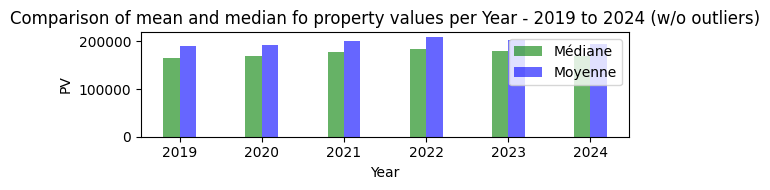

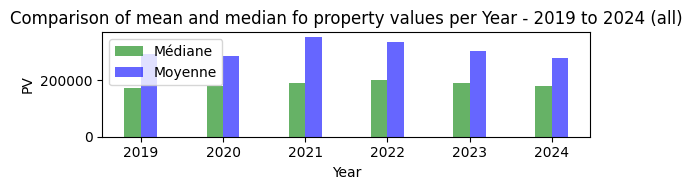

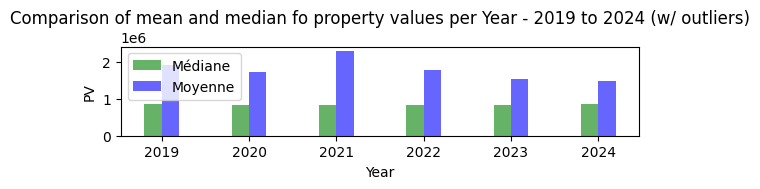

In [33]:
def plot_comparaison_moyenne_médiane():
    plt.figure(figsize=(6, 2))
    x = mean_nonoutliers['annee']
    offset = 0.1 
    plt.bar(x - offset, median_nonoutliers['Valeur fonciere'], width=offset * 2, label='Médiane', color='green', alpha=0.6)
    plt.bar(x + offset, mean_nonoutliers['Valeur fonciere'], width=offset * 2, label='Moyenne', color='blue', alpha=0.6)
    plt.title('Comparison of mean and median fo property values per Year - 2019 to 2024 (w/o outliers)')
    plt.xlabel('Year')
    plt.ylabel('PV')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparaison_moyenne_médiane()

def plot_comparaison_moyenne_médiane_all():
    plt.figure(figsize=(6, 2))
    x = mean_outliers['annee']
    offset = 0.1 
    plt.bar(x - offset, median_peryear['Valeur fonciere'], width=offset * 2, label='Médiane', color='green', alpha=0.6)
    plt.bar(x + offset, mean_peryear['Valeur fonciere'], width=offset * 2, label='Moyenne', color='blue', alpha=0.6)
    plt.title('Comparison of mean and median fo property values per Year - 2019 to 2024 (all)')
    plt.xlabel('Year')
    plt.ylabel('PV')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparaison_moyenne_médiane_all()

def plot_comparaison_moyenne_médiane_outliers():
    plt.figure(figsize=(6, 2))
    # Placer la médiane et la moyenne côte à côte
    x = mean_outliers['annee']
    offset = 0.1 
    plt.bar(x - offset, median_outliers['Valeur fonciere'], width=offset * 2, label='Médiane', color='green', alpha=0.6)
    plt.bar(x + offset, mean_outliers['Valeur fonciere'], width=offset * 2, label='Moyenne', color='blue', alpha=0.6)
    plt.title('Comparison of mean and median fo property values per Year - 2019 to 2024 (w/ outliers)')
    plt.xlabel('Year')
    plt.ylabel('PV')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparaison_moyenne_médiane_outliers()


#### Zooming on the impact of outliers ####

The standard deviation measures the dispersion of values around the mean. Outliers directly affect this measure, as the standard deviation is particularly sensitive to extreme values.

In [34]:
annual_stats_with_outliers=df_clean.groupby('annee')['Valeur fonciere'].agg(['std']).reset_index()
print('Standard deviation (w/outliers) : ')
annual_stats_with_outliers

Standard deviation (w/outliers) : 


,annee,std
0,2019,2.152591e+06
1,2020,1.944404e+06
2,2021,1.486710e+07
3,2022,2.983839e+06
4,2023,1.691317e+06
5,2024,1.100019e+06


In [35]:
annual_stats_outliers=outliers.groupby('annee')['Valeur fonciere'].agg(['std']).reset_index()
print('Standard deviation of outliers only : ')
annual_stats_outliers

Standard deviation of outliers only : 


,annee,std
0,2019,8.675388e+06
1,2020,7.753397e+06
2,2021,5.546531e+07
3,2022,1.035880e+07
4,2023,5.975738e+06
5,2024,4.041984e+06


To understand why the standard deviation is so high, it is important to explore the potential causes of this dispersion.

We will quickly look at the outliers (extreme values) for each year:

In [21]:
hvp=high_value_properties_sorted.groupby('annee')

def top_values_prop(annee):
    mostexp_by_year= hvp.get_group(annee).sort_values(by='Valeur fonciere', ascending=False).head(10)
    display(mostexp_by_year)

annee_widget=widgets.Dropdown(
    options=sorted(high_value_properties_sorted['annee'].unique()),description='Année : ',disabled=False
)
widgets.interactive(top_values_prop, annee=annee_widget)

interactive(children=(Dropdown(description='Année : ', options=(2019, 2020, 2021, 2022, 2023, 2024), value=201…

The table above shows the 10 most expensive properties each year. It is noticeable that commercial properties are generally the most expensive. This can be explained in several ways:

Commercial properties such as offices and shopping centers often have large spaces, and they are often dedicated to luxury businesses or major brands. These are spaces that require specific fittings and designs.
They may also attract large investors, such as Real Estate Managers (REM), who are interested in these types of properties.  

###### Examples: In 2021, the sale in Arcueil (94), Nelson Mandela Road, corresponds to a set of buildings that houses the headquarters of Orange and has undergone renovation work. (Source: CFNewsimmo https://www.cfnewsimmo.net/Annuaires-base-de-deals/Base-de-deals/Transaction-LES-PORTES-D-ARCUEIL-1-AVENUE-DU-PRESIDENT-NELSON-MANDELA-94110-ARCUEIL-lundi-12-juillet-2021) ######

###### Another example seems to be the transaction involving Chanel at 42 Avenue Montaigne in 2024, with 600m2 of retail space. According to CFNewsimmo, the transaction amount is "slightly above the 250M€ mark, which corresponds to the land value we have in the table." (english translation) (https://www.cfnewsimmo.net/Les-Alertes-de-CFNEWS-IMMO/Chanel-ajoute-le-42-Montaigne-a-sa-collection-471870)
######

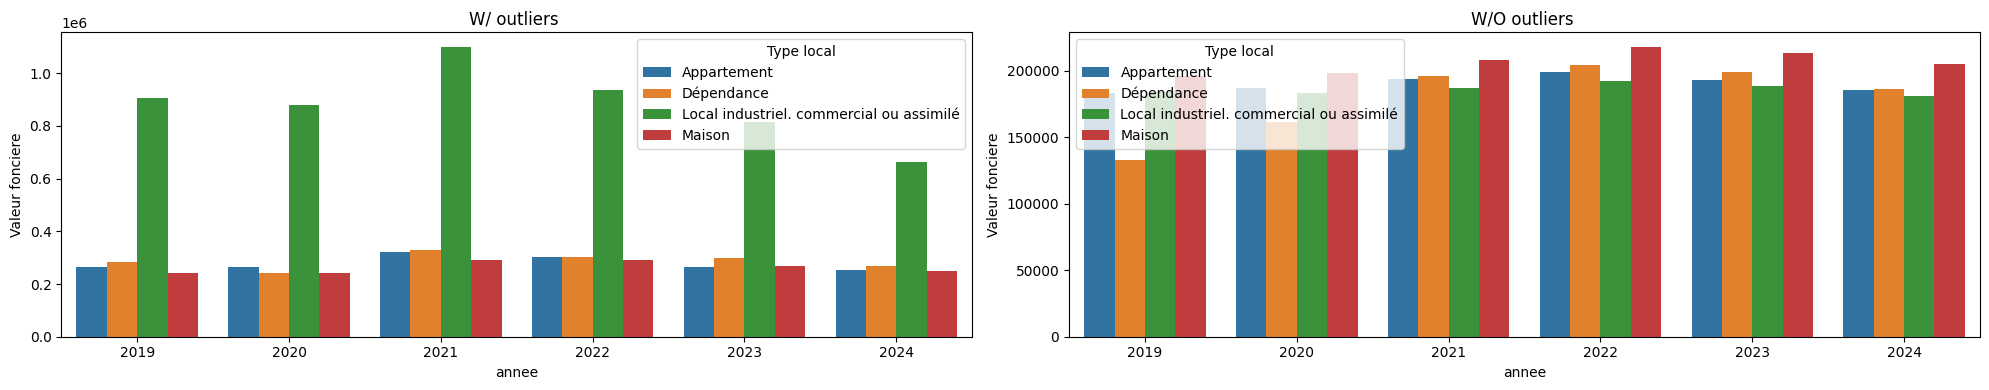

In [36]:
#comparing PV per type of property w and w/o outliers 
compare_all_type = df_clean.groupby(['annee', 'Type local'], observed=False).agg({'Valeur fonciere': 'mean'}).reset_index()
compare_nonoutliers_type = non_outliers.groupby(['annee', 'Type local'],observed=False).agg({'Valeur fonciere': 'mean'}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.barplot(x='annee', y='Valeur fonciere', hue='Type local', data=compare_all_type, ax=ax[0])
ax[0].set_title('W/ outliers ')

sns.barplot(x='annee', y='Valeur fonciere', hue='Type local', data=compare_nonoutliers_type, ax=ax[1])
ax[1].set_title('W/O outliers ')

plt.tight_layout()
plt.show()

The figures above allow for a comparison of land values by property type. It is clear that outliers mainly represent commercial/industrial properties, with values above 600 000€. In 2021, these properties even surpassed 1M€.

Without the outliers, it is generally houses that show the highest values, but overall, property prices range between 150 000€ and 250 000€. Despite the variation in exceptional transactions, regardless of the type of property, the price of real estate remains relatively stable and falls within a much more modest range.

### 2.3 Impact of potential external events on property value trend ###

Let's observe the peaks of increase and decrease in the following graph:

In [39]:
mutations_analyse_wo_outliers=non_outliers.copy()
mutations_analyse_wo_outliers['Date mutation'] = pd.to_datetime(mutations_analyse_wo_outliers['Date mutation'])
#mutations_analyse_wo_outliers['Annee'] = mutations_analyse_wo_outliers['Date mutation'].dt.year
mutations_analyse_wo_outliers['Annee-Mois'] = mutations_analyse_wo_outliers['Date mutation'].dt.to_period('M').astype(str)

def plot_interactive(annee_range, show_median=True, show_mean=True):
    # Filtrer les données par plage d'années et de mois
    filtered_data = mutations_analyse_wo_outliers[
        (mutations_analyse_wo_outliers['annee'] >= annee_range[0]) & 
        (mutations_analyse_wo_outliers['annee'] <= annee_range[1])
    ]    
    
    # Calcul des moyennes et des médianes pour la période et le type de bien filtrés
    prix_moyens = (
        filtered_data.groupby(['Annee-Mois'])['Valeur fonciere']
        .mean()
        .reset_index(name='mean_price')
    )
    
    prix_medians = (
        filtered_data.groupby(['Annee-Mois'])['Valeur fonciere']
        .median()
        .reset_index(name='median_price')
    )

    # Graphique de la moyenne et de la médiane
    plt.figure(figsize=(15, 6))
    
    if show_mean:
        sns.lineplot(
            data=prix_moyens,
            x='Annee-Mois', y='mean_price',
            label='Mean', marker='o', color='blue'
        )
        
    if show_median:
        sns.lineplot(
            data=prix_medians,
            x='Annee-Mois', y='median_price',
            label='Median', marker='o', color='orange'
        )
    
    plt.title('Prices evolutions per month and year (w/o outliers)')
    plt.xlabel('Time (Year-Month)')
    plt.ylabel('Price (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Stats')
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2019, 2023],
    min=2019, max=2024, step=1,
    description='Years :',
    continuous_update=False
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    show_median=widgets.Checkbox(value=True, description="Show median"),
    show_mean=widgets.Checkbox(value=True, description="Show mean")
)

interactive(children=(IntRangeSlider(value=(2019, 2023), continuous_update=False, description='Years :', max=2…

<function __main__.plot_interactive(annee_range, show_median=True, show_mean=True)>

In [69]:
def plot_interactive(annee_range, type_bien='Maison', show_median=True, show_mean=True):
    filtered_data = mutations_analyse_wo_outliers[
        (mutations_analyse_wo_outliers['annee'] >= annee_range[0]) & 
        (mutations_analyse_wo_outliers['annee'] <= annee_range[1])
    ]
    
    if type_bien: 
        filtered_data = filtered_data[filtered_data['Type local'] == type_bien]
    
    sequences = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)
        .size()
        .reset_index(name='count')
    )
    
    prix_moyens = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)['Valeur fonciere']
        .mean()
        .reset_index(name='mean_price')
    )

    prix_medians= (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)['Valeur fonciere']
        .median()
        .reset_index(name='median_price')
    )

    plt.figure(figsize=(15, 6))
    if show_mean:
        sns.lineplot(
        data=prix_moyens,
        x='Annee-Mois', y='mean_price',
        hue='Type local', marker='o', palette='viridis'
    )
        
    if show_median:
        sns.lineplot(
        data=prix_medians,
        x='Annee-Mois', y='median_price',
        hue='Type local', marker='o', palette='Set2'
    )
    
    plt.title('Price evolution per year and month (w/o outliers) per type')
    plt.xlabel('Time (Year-Month)')
    plt.ylabel('Price (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2021, 2023],
    min=2019, max=2024, step=1,
    description='Years :',
    continuous_update=False
)

type_bien_widget = widgets.Dropdown(
    options=list(mutations_analyse['Type local'].unique()),
    value=None,
    description="Type :"
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    type_bien=type_bien_widget,
    show_median=widgets.Checkbox(value=True, description="Show median "),
    show_mean=widgets.Checkbox(value=False, description="Show mean ")
)


interactive(children=(IntRangeSlider(value=(2021, 2023), continuous_update=False, description='Years :', max=2…

<function __main__.plot_interactive(annee_range, type_bien='Maison', show_median=True, show_mean=True)>

#### 2.3.1 - Analysis of the median ####


##### 1. Late 2019 - Early 2020 #####
Before the Covid-19 pandemic, land prices increased from 160 000€ to nearly 175 000€ in just one month. At that time, the European Central Bank (ECB) interest rate was very low (0%). Loans were very attractive, which could explain the real estate purchases.

##### 2. Decembre 2020 - January 2021 #####

Land prices rose from 160 000€ to 180 000€. Since the pandemic, criteria may have changed, with a greater need for space and comfort, especially in more rural areas to match the remote work environment. The ECB's interest rate remained very low, which made access to credit easier. However, the inflation of construction materials became noticeable (https://www.insee.fr/fr/statistiques/5396320), contributing to the rise in costs for new construction projects, and indirectly driving up land prices.

##### 3. 2022 - 2024 #####

From 2022 to 2023, a gradual decrease was observed, with prices dropping to around €175,000 by September 2024. Despite an increase in property tax by 7.1% by 2022/2023, several factors can explain this trend. First, after inflation, mortgage rates generally increased (from around 1.05% in early 2022 to 3.46% in November 2024), which may have reduced the population's purchasing power. 

In addition to the rising construction and material costs, the war in Ukraine caused energy prices to rise. The real estate market was therefore significantly slowed down due to monetary and energy policies, as well as economic conditions. 


Sources : 
- INSEE : Données sur l’inflation des matériaux de construction et l’évolution des coûts en 2021.
- Banque Centrale Européenne (BCE) : Politiques monétaires et impact sur l’emprunt immobilier. https://fr.tradingeconomics.com/euro-area/interest-rate 
- FMI : Analyses sur l’inflation et la reprise économique après la pandémie.
- Observatoire Crédit Logement : Rapport sur les taux d’intérêt et leur impact sur l’accès au crédit immobilier en 2022-2023.

### 2.3.2 Geographically related - few cases ###

On the figure below, we are comparing the mean prices evolution in major cities and others cities in France. 
Major departments are  75, 77, 78, 91, 92, 93, 94, 95, 31, 13, 59, 69, 44

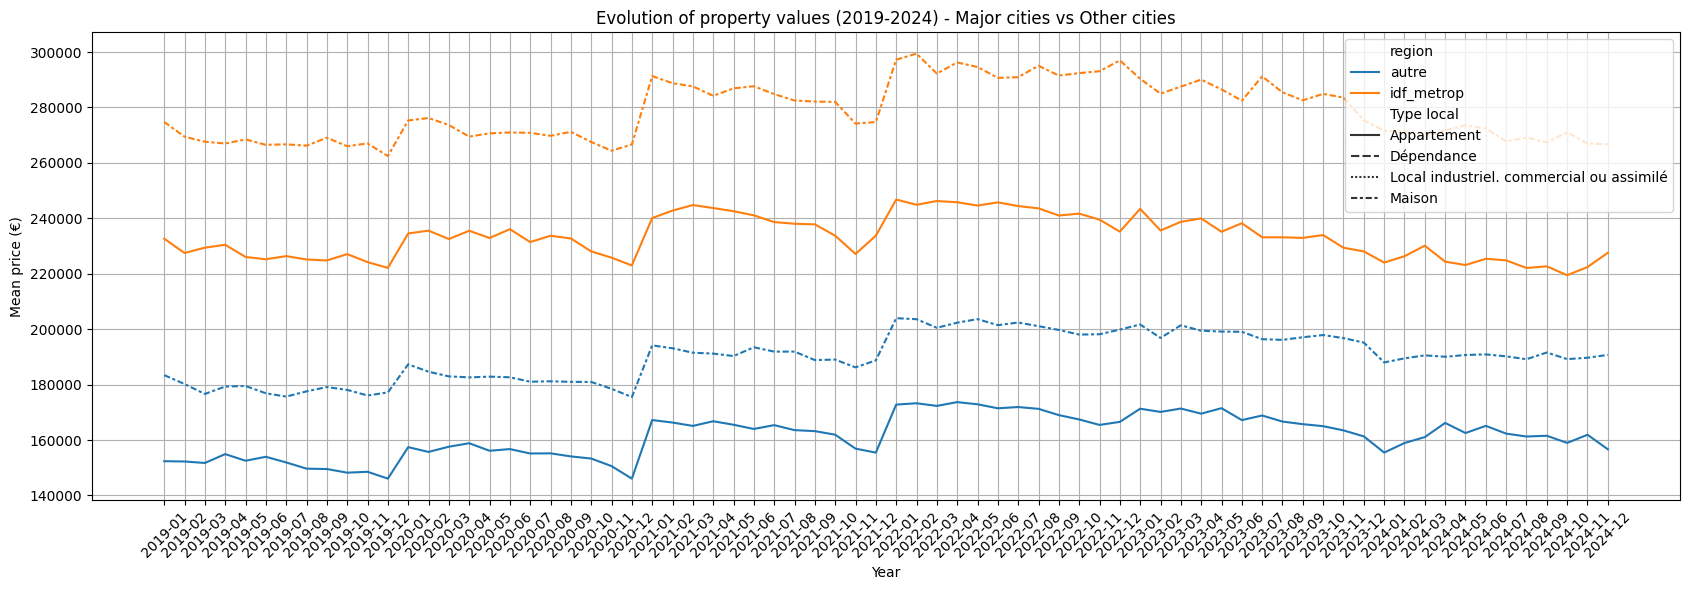

In [97]:
mutations_analyse_wo_outliers_idf = mutations_analyse_wo_outliers.copy()
idf_metrop = [75, 77, 78, 91, 92, 93, 94, 95,31, 13, 59, 69, 44]
mutations_analyse_wo_outliers_idf['Code departement'] = mutations_analyse_wo_outliers_idf['Code departement'].astype(str)

mutations_analyse_wo_outliers_idf['region'] = mutations_analyse_wo_outliers_idf['Code departement'].apply(
    lambda x: 'idf_metrop' if x in [str(dept) for dept in idf_metrop] else 'autre'
)
filtered_data = mutations_analyse_wo_outliers_idf[
    (mutations_analyse_wo_outliers_idf['annee'] >= 2019) & 
    (mutations_analyse_wo_outliers_idf['annee'] <= 2024) &
    (mutations_analyse_wo_outliers_idf['Type local'].isin(['Maison', 'Appartement']))  

]
prix_moyens = (
    filtered_data.groupby(['Annee-Mois', 'region', 'Type local'], as_index=False, observed=False)['Valeur fonciere']
    .mean()
    .rename(columns={'Valeur fonciere': 'mean_price'})
)
plt.figure(figsize=(17, 6))
sns.lineplot(data=prix_moyens, x='Annee-Mois', y='mean_price', hue='region', style='Type local')

plt.title('Evolution of property values (2019-2024) - Major cities vs Other cities')
plt.xlabel('Year')
plt.ylabel('Mean price (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



We can obviously notice that houses and apartments in big cities are more expensive than in other cities due to their attractivity including the access to amenities, cultural, social and economic opportunities, the proximity to strategic and economic infrastrucutre... The lines follow the same trend.

In this second case, we compare areas in Île-de-France with a comparable population density to those in other major cities outside of Île-de-France.

/var/folders/sr/6t4rh27j1v1fr55gfr9fvsv40000gn/T/ipykernel_47045/1785867299.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



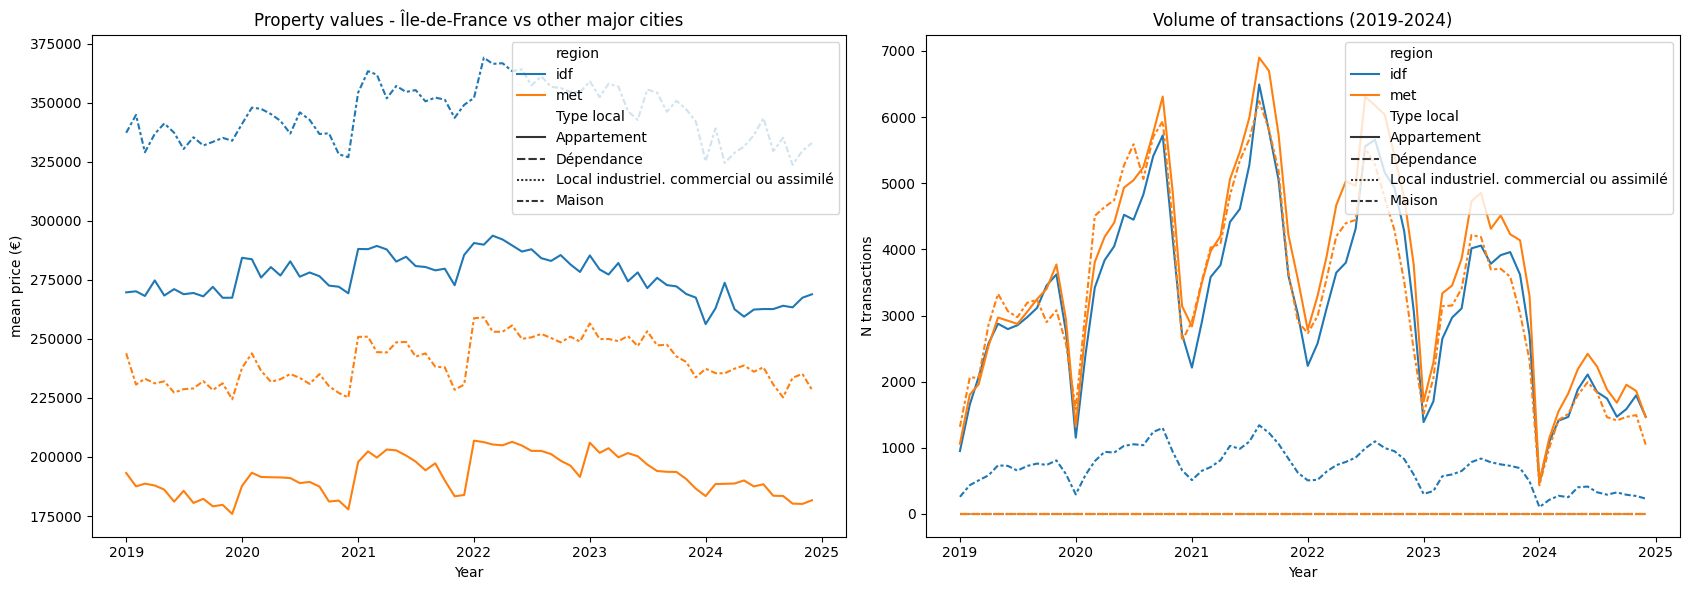

In [121]:
mutations_analyse_wo_outliers_idf = mutations_analyse_wo_outliers.copy()

idf = [75, 92, 93, 94, 95]
met = [13, 69, 59, 31, 34, 54]

mutations_analyse_wo_outliers_idf['Code departement'] = mutations_analyse_wo_outliers_idf['Code departement'].astype(str)

mutations_analyse_wo_outliers_idf['region'] = mutations_analyse_wo_outliers_idf['Code departement'].apply(
    lambda x: 'idf' if x in [str(dept) for dept in idf] else ('met' if x in [str(dept) for dept in met] else None)
)

filtered_data = mutations_analyse_wo_outliers_idf[
    (mutations_analyse_wo_outliers_idf['annee'] >= 2019) & 
    (mutations_analyse_wo_outliers_idf['annee'] <= 2024) & 
    (mutations_analyse_wo_outliers_idf['region'].notna()) & 
    (mutations_analyse_wo_outliers_idf['Type local'].isin(['Maison', 'Appartement']))  

]

filtered_data['Annee-Mois'] = pd.to_datetime(filtered_data['Annee-Mois'], errors='coerce')
prix_moyens = (
    filtered_data.groupby(['Annee-Mois', 'region', 'Type local'], observed=False, as_index=False)['Valeur fonciere']
    .mean()
    .rename(columns={'Valeur fonciere': 'mean_price'})
)
volume_transactions = (
    filtered_data.groupby(['Annee-Mois', 'region', 'Type local'], observed=False,as_index=False).size()
    .rename(columns={'size': 'transaction_count'})
)
fig, axes = plt.subplots(1, 2, figsize=(17, 6))

sns.lineplot(data=prix_moyens, x='Annee-Mois', y='mean_price', hue='region', style='Type local', ax=axes[0])
axes[0].set_title('Property values - Île-de-France vs other major cities')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('mean price (€)')
sns.lineplot(data=volume_transactions, x='Annee-Mois', y='transaction_count', hue='region', style='Type local', ax=axes[1])
axes[1].set_title('Volume of transactions (2019-2024)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('N transactions')

plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
df_taxe = pd.read_csv("taxe2021_2024.csv", delimiter=',')

columns_to_keep = [
    "DEPARTEMENT (numéro)",
    "EVOLUTION TAXE FONCIERE + TEOM 2021/2022 (majoration de 3,4 % des valeurs locatives comprise), en %",
    "EVOLUTION TAXE FONCIERE + TEOM 2022/2023 (majoration de 7,1 % des valeurs locatives comprise), en %",
    "EVOLUTION TAXE FONCIERE + TEOM 2023/2024 (majoration de 3,9 % des valeurs locatives comprise), en %"
]

existing_columns = df_taxe.columns.intersection(columns_to_keep)
df_taxe = df_taxe[existing_columns]

for col in columns_to_keep[1:]:
    if col in df_taxe.columns:
        df_taxe[col] = df_taxe[col].str.replace(r'[^\d.,-]', '', regex=True)
        df_taxe[col] = df_taxe[col].str.replace(',', '.', regex=False)
        df_taxe[col] = pd.to_numeric(df_taxe[col], errors='coerce')

if "DEPARTEMENT (numéro)" in df_taxe.columns:
    df_taxe['DEPARTEMENT (numéro)'] = pd.to_numeric(df_taxe['DEPARTEMENT (numéro)'], errors='coerce')

df_taxe_cleaned = df_taxe.dropna()

if "DEPARTEMENT (numéro)" in df_taxe_cleaned.columns:
    df_taxe_cleaned['DEPARTEMENT (numéro)'] = df_taxe_cleaned['DEPARTEMENT (numéro)'].astype(int)

df_taxe_cleaned.head()


/var/folders/sr/6t4rh27j1v1fr55gfr9fvsv40000gn/T/ipykernel_47045/3874243843.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxe_cleaned['DEPARTEMENT (numéro)'] = df_taxe_cleaned['DEPARTEMENT (numéro)'].astype(int)


,DEPARTEMENT (numéro),"EVOLUTION TAXE FONCIERE + TEOM 2021/2022 (majoration de 3,4 % des valeurs locatives comprise), en %","EVOLUTION TAXE FONCIERE + TEOM 2022/2023 (majoration de 7,1 % des valeurs locatives comprise), en %","EVOLUTION TAXE FONCIERE + TEOM 2023/2024 (majoration de 3,9 % des valeurs locatives comprise), en %"
2,13,3.9,15.8,4.2
4,81,3.4,7.6,4.0
5,30,5.9,7.4,3.8
6,94,3.4,7.4,4.1
7,80,3.4,8.8,4.2


Groupement des taxes par département pour faire la moyenne : 

In [28]:
df_taxe_dept = df_taxe_cleaned.groupby('DEPARTEMENT (numéro)', as_index=False).mean()

df_taxe_dept.rename(columns={
    "DEPARTEMENT (numéro)":"Code departement",
    "EVOLUTION TAXE FONCIERE + TEOM 2021/2022 (majoration de 3,4 % des valeurs locatives comprise), en %": "Moyenne Taxe 2021/2022",
    "EVOLUTION TAXE FONCIERE + TEOM 2022/2023 (majoration de 7,1 % des valeurs locatives comprise), en %": "Moyenne Taxe 2022/2023",
    "EVOLUTION TAXE FONCIERE + TEOM 2023/2024 (majoration de 3,9 % des valeurs locatives comprise), en %": "Moyenne Taxe 2023/2024"
}, inplace=True)
df_taxe_dept.head()


,Code departement,Moyenne Taxe 2021/2022,Moyenne Taxe 2022/2023,Moyenne Taxe 2023/2024
0,1,3.6,7.300000,6.900000
1,2,3.4,8.600000,3.900000
2,5,3.4,8.400000,7.500000
3,6,3.4,9.466667,7.933333
4,10,8.5,19.500000,3.000000


In [42]:
'''from sklearn.linear_model import LinearRegression

df_combined = pd.merge(df_taxe_dept, mutations_analyse_wo_outliers, how='inner', on='Code departement')
df_taxe_dept['Code departement'] = df_taxe_dept['Code departement'].astype(str)
mutations_analyse_wo_outliers['Code departement'] = mutations_analyse_wo_outliers['Code departement'].astype(str)

#standardisation 
df_taxe_dept['Code departement'] = df_taxe_dept['Code departement'].str.zfill(2).str.strip()
mutations_analyse_wo_outliers['Code departement'] = mutations_analyse_wo_outliers['Code departement'].str.zfill(2).str.strip()
df_combined = df_combined[df_combined['annee'] >= 2021]

def attribuer_taxe_fonciere(row):
    if row['annee'] == 2021:
        return row['Moyenne Taxe 2021/2022']
    elif row['annee'] == 2022:
        return row['Moyenne Taxe 2022/2023']
    elif row['annee'] == 2023 | 2024:
        return row['Moyenne Taxe 2023/2024']
    else:
        return None 

df_combined['Taxe Foncière'] = df_combined.apply(attribuer_taxe_fonciere, axis=1)
df_combined.head()'''

"from sklearn.linear_model import LinearRegression\n\ndf_combined = pd.merge(df_taxe_dept, mutations_analyse_wo_outliers, how='inner', on='Code departement')\ndf_taxe_dept['Code departement'] = df_taxe_dept['Code departement'].astype(str)\nmutations_analyse_wo_outliers['Code departement'] = mutations_analyse_wo_outliers['Code departement'].astype(str)\n\n#standardisation \ndf_taxe_dept['Code departement'] = df_taxe_dept['Code departement'].str.zfill(2).str.strip()\nmutations_analyse_wo_outliers['Code departement'] = mutations_analyse_wo_outliers['Code departement'].str.zfill(2).str.strip()\ndf_combined = df_combined[df_combined['annee'] >= 2021]\n\ndef attribuer_taxe_fonciere(row):\n    if row['annee'] == 2021:\n        return row['Moyenne Taxe 2021/2022']\n    elif row['annee'] == 2022:\n        return row['Moyenne Taxe 2022/2023']\n    elif row['annee'] == 2023 | 2024:\n        return row['Moyenne Taxe 2023/2024']\n    else:\n        return None \n\ndf_combined['Taxe Foncière'] = df_

In [41]:
'''from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df_combined_clean = df_combined.dropna(subset=['Taxe Foncière'])

X = df_combined_clean[['Surface reelle bati', 'Surface terrain', 'Nombre pieces principales', 'Valeur fonciere']]
y = df_combined_clean['Taxe Foncière']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(f"Ensemble d'entraînement: X_train: {X_train.shape}, y_train: {y_train.shape}")
#print(f"Ensemble de test: X_test: {X_test.shape}, y_test: {y_test.shape}")
rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20, None],  # Profondeur maximale des arbres
    'min_samples_split': [2, 5],  # Nombre minimum d'échantillons pour couper un nœud
    'min_samples_leaf': [1, 2]    # Nombre minimum d'échantillons pour qu'un nœud soit une feuille
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Score R² sur les données de test : {r2}")
print(f"MSE sur les données de test : {mse}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # ligne parfaite
plt.xlabel("Valeurs réelles de la Taxe Foncière")
plt.ylabel("Valeurs prédites de la Taxe Foncière")
plt.title("Réelles vs Prédites - Taxe Foncière")
plt.show()
'''


'from sklearn.model_selection import train_test_split, GridSearchCV\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\n\ndf_combined_clean = df_combined.dropna(subset=[\'Taxe Foncière\'])\n\nX = df_combined_clean[[\'Surface reelle bati\', \'Surface terrain\', \'Nombre pieces principales\', \'Valeur fonciere\']]\ny = df_combined_clean[\'Taxe Foncière\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n#print(f"Ensemble d\'entraînement: X_train: {X_train.shape}, y_train: {y_train.shape}")\n#print(f"Ensemble de test: X_test: {X_test.shape}, y_test: {y_test.shape}")\nrf_model = RandomForestRegressor(random_state=42)\n\nparam_grid = {\n    \'n_estimators\': [100, 200],  \n    \'max_depth\': [10, 20, None],  # Profondeur maximale des arbres\n    \'min_samples_split\': [2, 5],  # Nombre minimum d\'échantillons pour couper un nœud\n    \'min_samples_leaf\': [1, 2]    # Nombre minimum d\'é